**IMPORTS**

In [8]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# important libraries
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
sns.set(rc={'figure.figsize': (20,10)})

**Exploratory Data Analysis(EDA)**

Dataset

In [10]:
csv_collection = []
for dirname, _, filenames in os.walk('../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows'):
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        csv_collection.append(fullpath)

In [11]:
csv_collection

['../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1213_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230130_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230113_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1030_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230102_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/20230203_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/0928_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/0905_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/1002_UkraineCombinedTweetsDeduped.csv.gzip',
 '../input/ukraine-russian-cri

In [12]:
df = pd.read_csv(csv_collection.pop(), compression='gzip', index_col=0, dtype={'column_name': str})
for data in csv_collection:
    try:
        tmp = pd.read_csv(data, compression = 'gzip', index_col=0,low_memory=False)
    except:
            tmp = pd.read_csv(data, index_col = 0)
            df = pd.concat([df, tmp], axis=0)

/tmp/ipykernel_42/2882285012.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_collection.pop(), compression='gzip', index_col=0, dtype={'column_name': str})


**Data Cleaning**

In [13]:
df.shape

(229813, 28)

In [14]:
df.columns

Index(['userid', 'username', 'acctdesc', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'language', 'coordinates',
       'favorite_count', 'is_retweet', 'original_tweet_id',
       'original_tweet_userid', 'original_tweet_username',
       'in_reply_to_status_id', 'in_reply_to_user_id',
       'in_reply_to_screen_name', 'is_quote_status', 'quoted_status_id',
       'quoted_status_userid', 'quoted_status_username', 'extractedts'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229813 entries, 0 to 229812
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   userid                   229813 non-null  int64 
 1   username                 229813 non-null  object
 2   acctdesc                 190947 non-null  object
 3   location                 141543 non-null  object
 4   following                229813 non-null  int64 
 5   followers                229813 non-null  int64 
 6   totaltweets              229813 non-null  int64 
 7   usercreatedts            229813 non-null  object
 8   tweetid                  229813 non-null  int64 
 9   tweetcreatedts           229813 non-null  object
 10  retweetcount             229813 non-null  int64 
 11  text                     229813 non-null  object
 12  hashtags                 229813 non-null  object
 13  language                 229813 non-null  object
 14  coordinates              

In [16]:
df.isna().sum().sort_values(ascending=False)

coordinates                229639
quoted_status_username     219330
in_reply_to_screen_name    213152
original_tweet_username     97104
location                    88270
acctdesc                    38866
favorite_count                  0
quoted_status_userid            0
quoted_status_id                0
is_quote_status                 0
in_reply_to_user_id             0
in_reply_to_status_id           0
original_tweet_userid           0
original_tweet_id               0
is_retweet                      0
userid                          0
username                        0
language                        0
hashtags                        0
text                            0
retweetcount                    0
tweetcreatedts                  0
tweetid                         0
usercreatedts                   0
totaltweets                     0
followers                       0
following                       0
extractedts                     0
dtype: int64

In [17]:
df = df.dropna(subset=['location'])

**Tweets arranged according to Language of the tweets**

In [18]:
df.language.value_counts()

language
en     97130
und     7841
de      7453
it      6255
fr      5398
es      4642
ja      2300
uk      1568
ru      1349
pl       770
tr       737
el       650
hi       595
pt       482
in       416
fi       372
ar       350
nl       321
zh       262
ta       257
bn       225
sv       211
ro       184
ca       147
th       136
da       135
cs       131
ur       127
et       105
tl       105
ml        84
mr        80
si        69
ko        64
no        60
lv        59
gu        50
fa        42
vi        42
ne        36
ht        35
cy        27
hu        26
lt        24
kn        23
bg        22
te        21
iw        20
sl        17
eu        15
sr        13
ka        13
or        11
pa        10
is         8
ps         8
my         7
am         1
hy         1
ckb        1
Name: count, dtype: int64

**Plotting the tweets based on language**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='language', ylabel='count'>

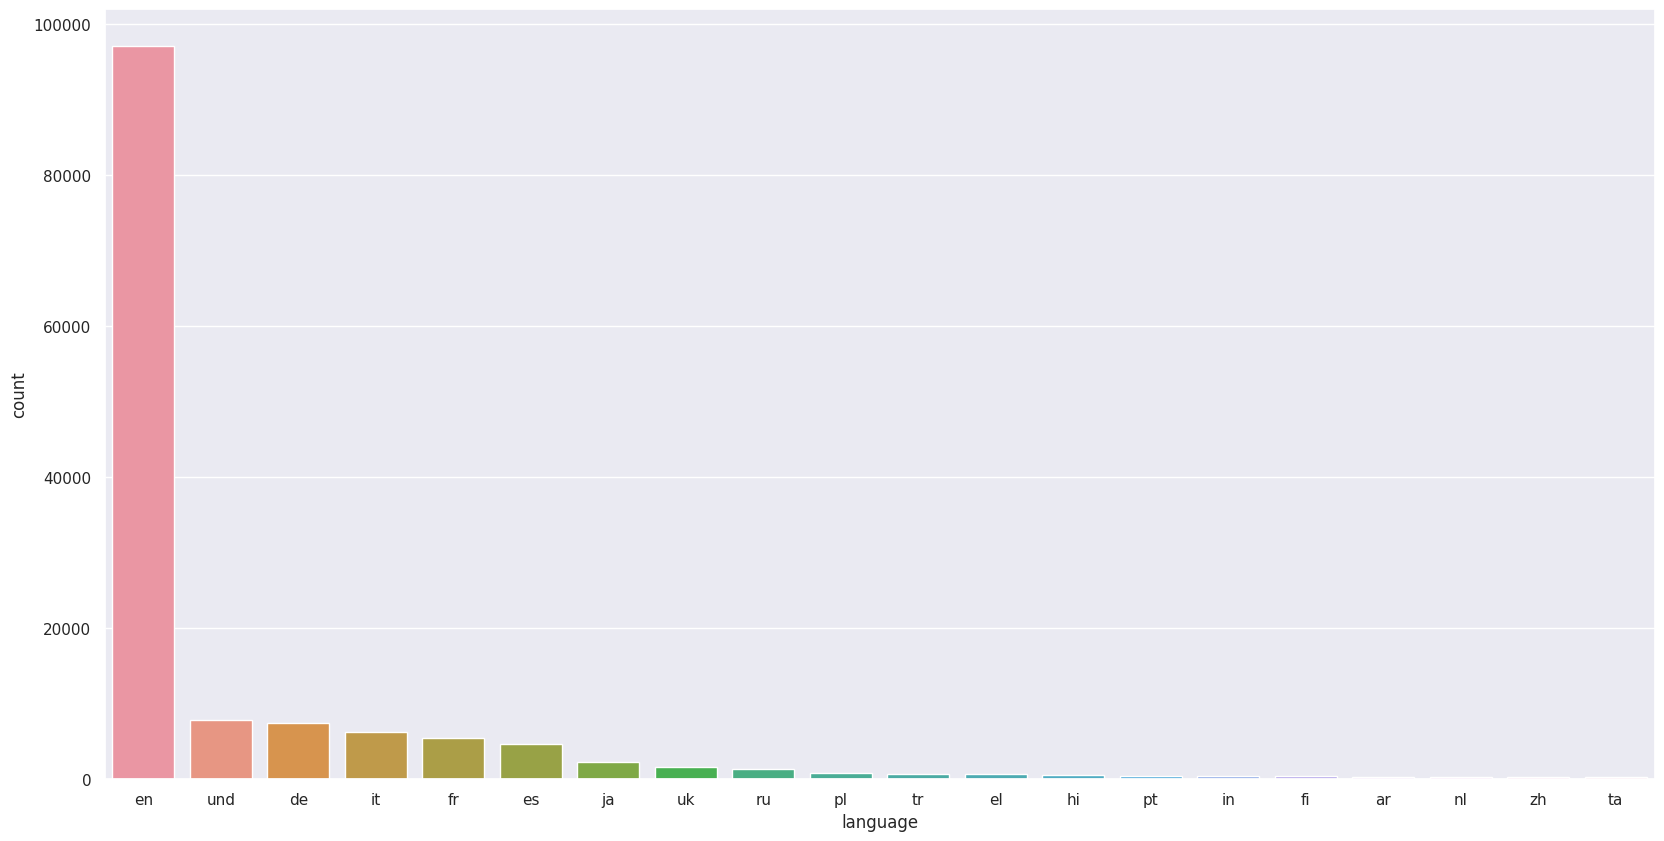

In [19]:
sns.barplot(x= df.language.value_counts()[:20].index,y=df.language.value_counts()[:20])

**Unique Tweets based on language**

In [20]:
df.groupby('language').nunique()

userid  username  acctdesc  location  following  followers  \
language                                                               
am             1         1         1         1          1          1   
ar           172       172       161       143        176        211   
bg             8         8         7         7          8         10   
bn            26        26        26        13         25         87   
ca           129       129       124       108        126        138   
ckb            1         1         1         1          1          1   
cs            95        95        86        76         98        103   
cy            24        24        23        23         24         27   
da           119       119       108        92        115        118   
de          4202      4202      3840      2228       2239       2593   
el           211       211       175       144        215        249   
en         44629     44641     41079     20514       8229      12224   
es          2446      2446      2259      1469       1823       2197   
et            90        90        81        88         89         91   
eu            14        14        14        14         15         15   
fa            32        32        30        27         33         33   
fi           286       286       275       166        278        284   
fr          3395      3395      2990      1908       2062       2327   
gu            17        17        17        13         17         27   
hi           224       224       217       125        190        273   
ht            29        29        27        28         28         30   
hu            23        23        22        22         23         25   
hy             1         1         1         1          1          1   
in           173       173       163       145        156        186   
is             7         7         7         7          7          7   
it          2869      2870      2548      1499       1976       2272   
iw             6         6         5         6          6          9   
ja          1101      1101      1075       869        764        781   
ka             3         3         2         3          3          4   
kn            11        11        11         6         10         21   
ko            47        47        45        41         49         49   
lt            17        17        16        17         17         18   
lv            52        52        40        28         50         54   
ml             5         5         5         5          5          6   
mr            22        22        22        15         22         39   
my             6         6         4         6          6          6   
ne             3         3         3         3          3          3   
nl           229       229       222       173        233        235   
no            53        53        47        49         53         57   
or             5         5         5         5          5          8   
pa             5         5         5         5          5          7   
pl           466       466       430       273        444        501   
ps             3         3         3         3          3          5   
pt           237       237       215       174        218        268   
ro           116       116       111       101        109        127   
ru           522       522       424       382        448        474   
si            10        10         9         4          9         23   
sl            14        14        14        14         14         14   
sr             7         7         7         7          8          8   
sv           140       140       132        89        143        147   
ta           134       134       126        82        136        162   
te            12        12        12         8         10         17   
th            81        81        73        56         81         77   
tl            90        90        86        89    

**Dataset with only English as tweet language**

In [21]:
df_en = df[df.language == 'en'].drop('language', axis=1)

**Sorting the Tweets based on Retweet count**

In [22]:
sorted_tweets = df_en[['username', 'text','retweetcount','tweetid', ]].sort_values(by = 'retweetcount', ascending=False)

**Most Retweeted Tweet**

In [23]:
most_retweeted = sorted_tweets.iloc[0]
print(most_retweeted.text)

This, out of #Ukraine, is 100% one of the most incredible videos I have ever seen.

This Russian POW has the heart of a lion 🦁 https://t.co/KIx1rsN0CZ


In [24]:
sorted_tweets.tweetid.iloc[0]

1527481645611200512

**Top 10 Most Retweeted Tweets**

In [25]:
sorted_tweets.head(10)

username                                               text  \
18887      chasman_paul  This, out of #Ukraine, is 100% one of the most...   
134599  MaryMarybrogdon  Little girl singing "Let it go" in a shelter\n...   
131449  ChrisAlbertoLaw  Little girl singing "Let it go" in a shelter\n...   
157014        billyb196  JUST IN: #Russian state TV channels have been ...   
191098    matteo_casaro  The Anonymous collective is officially in cybe...   
178562           holbdy  The Anonymous collective is officially in cybe...   
197816      thetrocro__  To the free people of the world!\n\nWe feel yo...   
3733        Forward2021  Thank you @RussiaUN for your letter dated Marc...   
31993        interwaved  This is Iryna before #Russia came to our land....   
157518     natariyasama  This is Iryna before #Russia came to our land....   

        retweetcount              tweetid  
18887         103473  1527481645611200512  
134599         76855  1527660214744399876  
131449         76854  1527655770547945472  
157014         60446  1527689008914092033  
191098         52556  1527736766991671299  
178562         52555  1527719458516631553  
197816         35496  1527746621991165954  
3733           34722  1527448129703882753  
31993          30665  1527511560922443776  
157518         30664  1527689626957271041

**WordCloud with STOPWORDS**

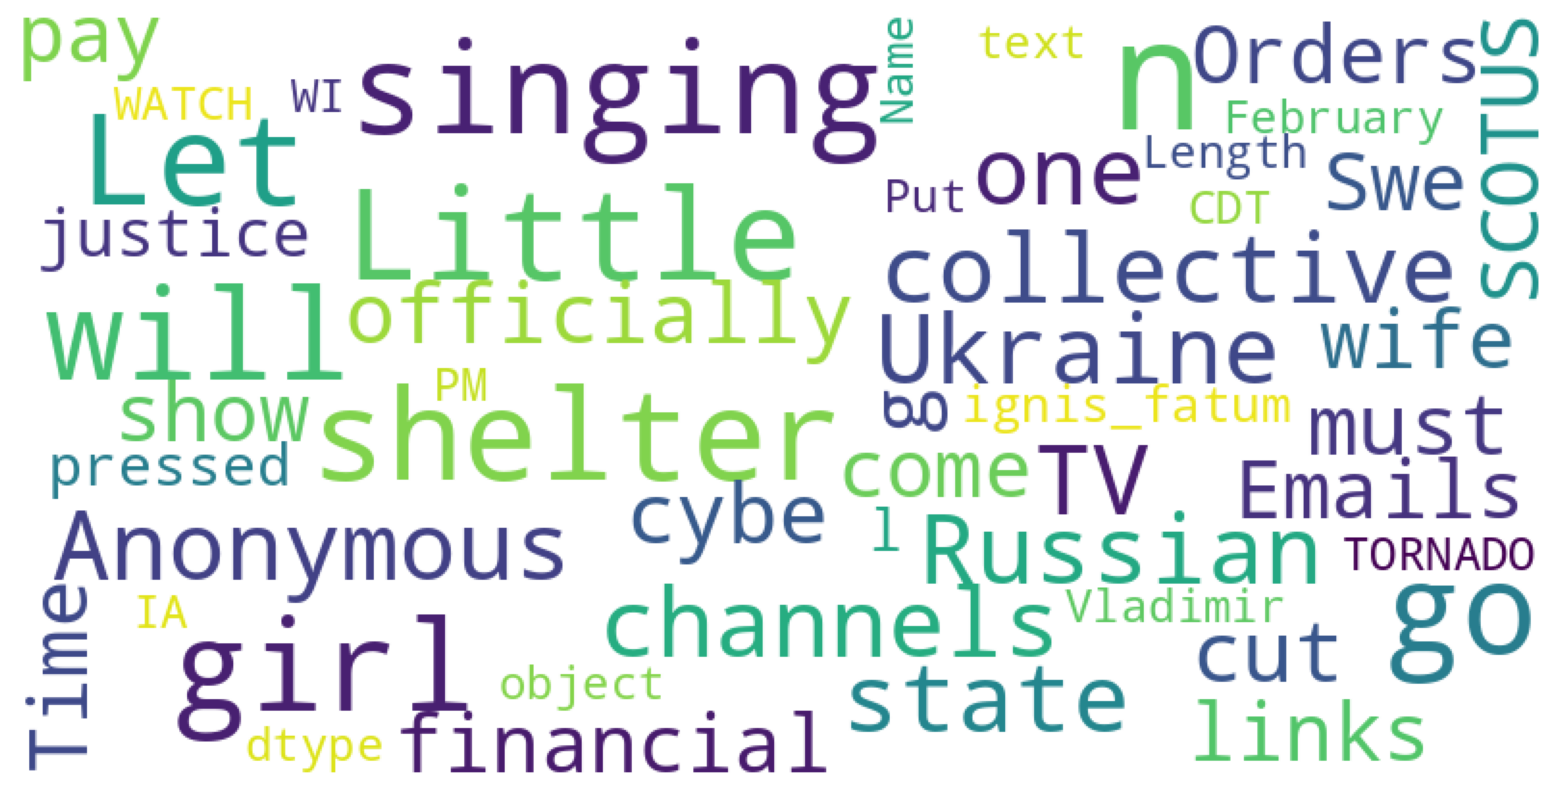

In [26]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(sorted_tweets['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Unique Tweets**

In [27]:
unique_tweets = df_en.drop_duplicates(subset = ['text'])

**Plotting the number of tweets based on the location of the tweet**

<Axes: xlabel='location'>

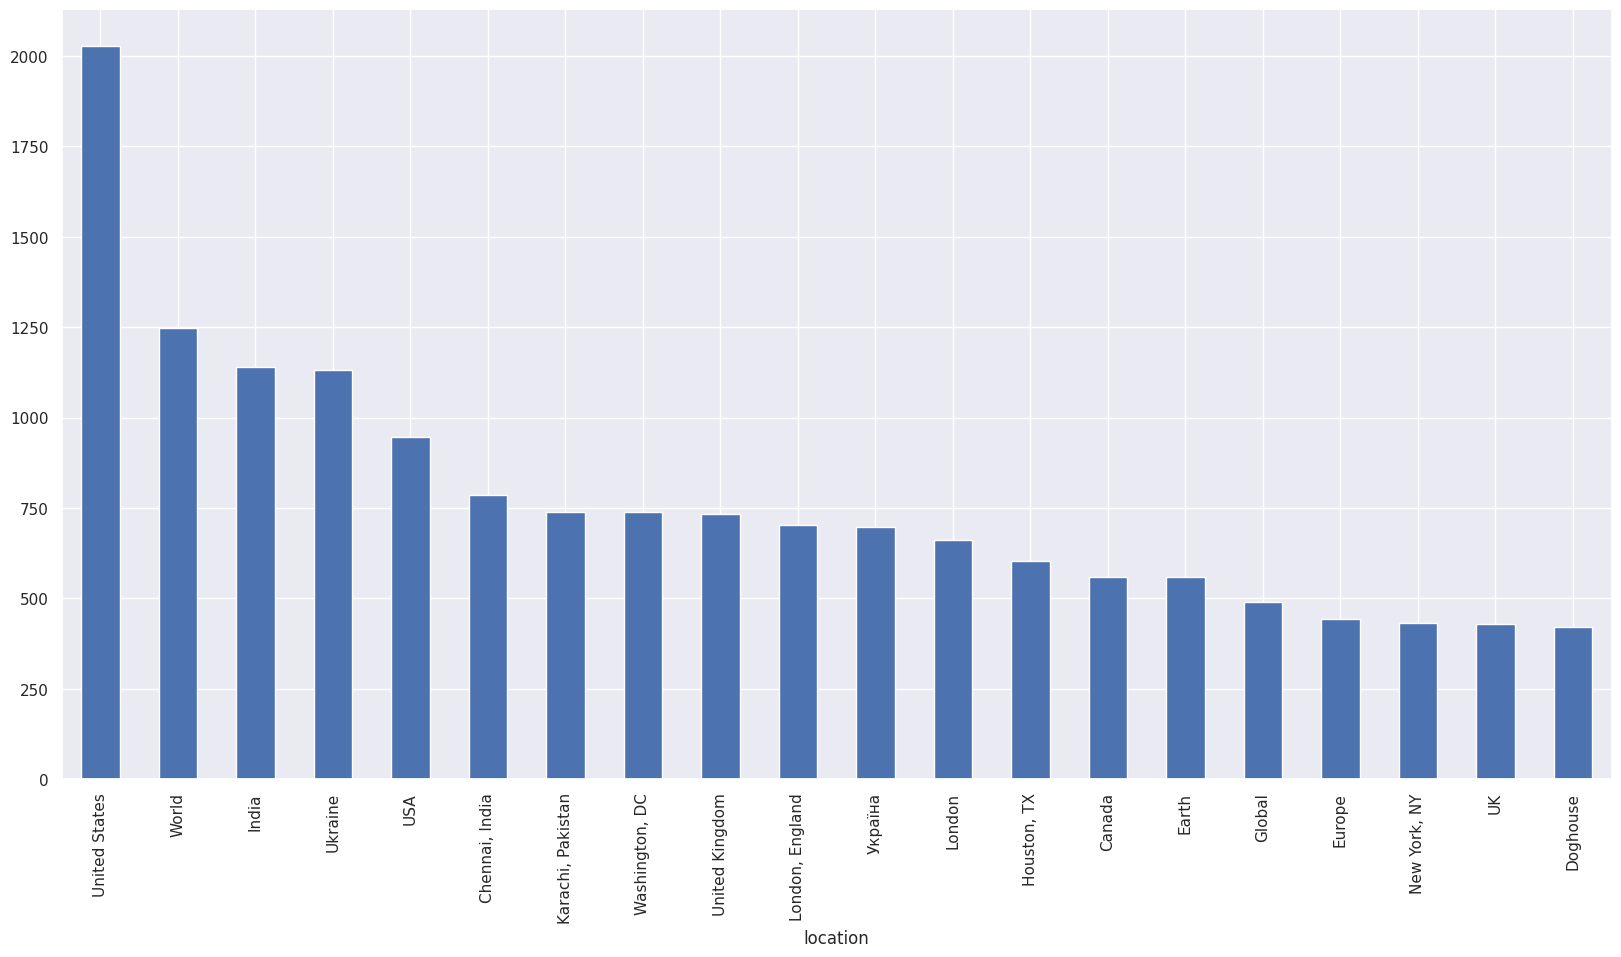

In [28]:
df_en.location.value_counts()[:20].plot.bar()

**Wordclouds using nltk stopwords based on unique tweets**

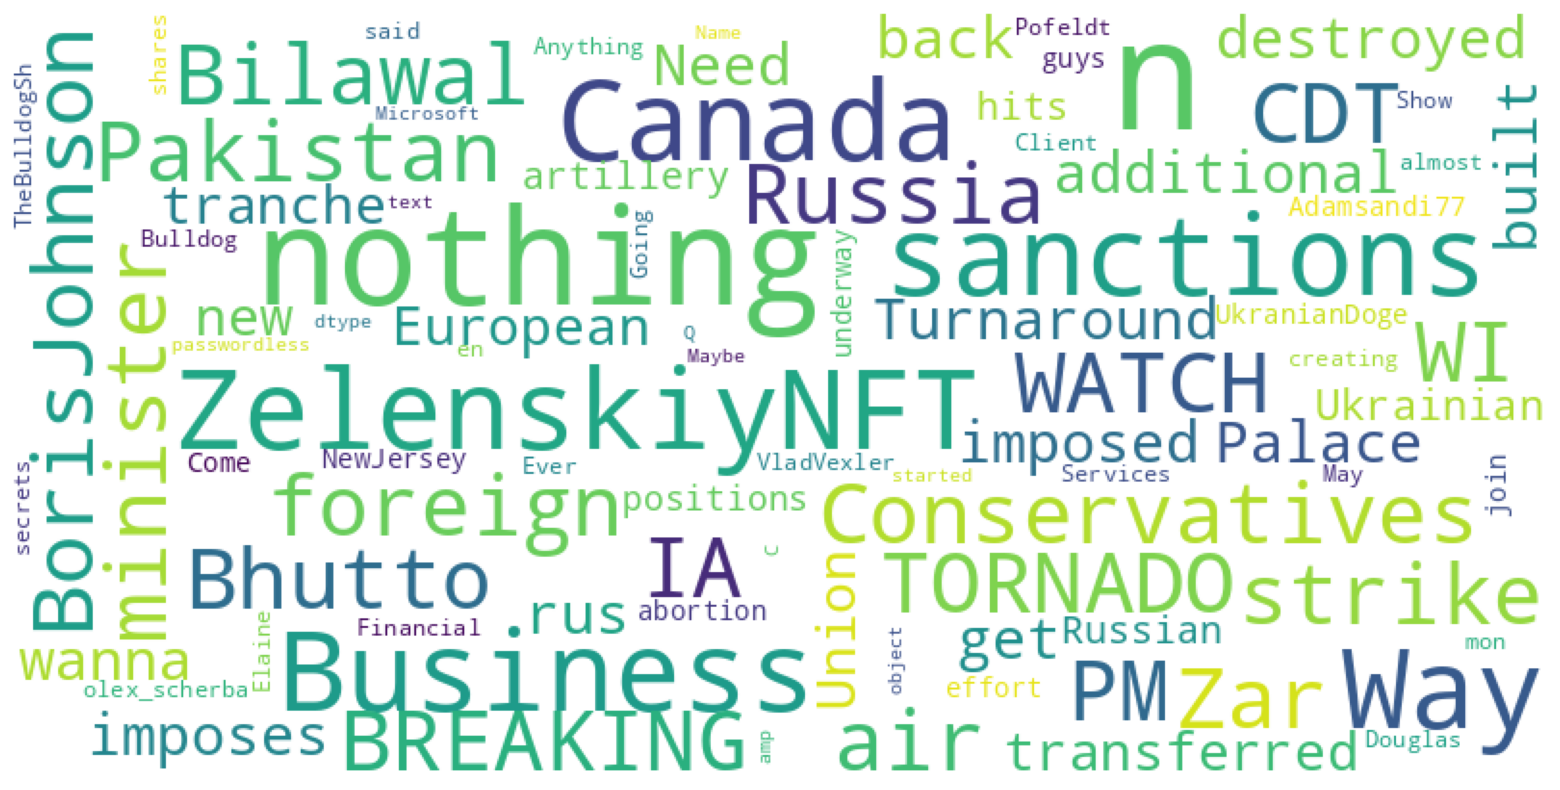

In [29]:
stopwords_set = set(stopwords.words('english'))
wordcloud= WordCloud(background_color = 'white',
                    stopwords=stopwords_set,
                    max_words=300,
                    max_font_size=40,
                    scale = 2,
                    random_state=42
                    ).generate(str(unique_tweets.sort_values(by = 'retweetcount').iloc[:20]['text']))
print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Columns with time as a feature**

In [30]:
time_cols = ['extractedts','tweetcreatedts','usercreatedts']

In [31]:
df_en[time_cols[2]] = pd.to_datetime(df_en[time_cols[2]])

In [32]:
df_en.head(10)

userid         username  \
2             183688400      livewxradar   
5            3874439667     CptSeaMonkey   
6              22240612    AlArabiya_Eng   
7   1275475606684172290       medyanews_   
8              50687619      CommTimesSC   
10  1023285701872377856        ScoopusaM   
11            629725842          HNGNcom   
12  1356632630662430722  DogandCatHelpe1   
13   882240636010868736  NowBitcoinPrice   
14            135922295        kuriharan   

                                             acctdesc              location  \
2   Totally into #weather #snow & #tornadoes..Weat...                   USA   
5   Follow & Like\n\nThe DNC is a Fascist Socialis...        Louisiana, USA   
6   The Arab world’s leading source of global news...                 Dubai   
7   Medya News offers news, stories, columns, rese...  Kurdistan, Worldwide   
8   The Community Times Newspaper and Magazine and...          Florence, SC   
10  Our mission is to provide a platform to discus...      Philadelphia, PA   
11                            Headlines & Global News         New York City   
12  Shelter for abandoned dogs and cats. 1400 dogs...               Ukraine   
13  #Bitcoin price updates every 30 minutes #BTC #...               Bitcoin   
14  Co-founder @pbdlab, develop data privacy cultu...       Tokyo-to, Japan   

    following  followers  totaltweets       usercreatedts  \
2        3934       5033       156411 2010-08-27 17:00:25   
5         102        388        25686 2015-10-05 21:14:40   
6          46     915339       316622 2009-02-28 08:31:32   
7         224       6496         7698 2020-06-23 17:07:56   
8        1817        496          430 2009-06-25 16:12:30   
10        239        108         1586 2018-07-28 19:14:57   
11       2186       2853        28072 2012-07-07 21:05:25   
12          5         33          475 2021-02-02 15:57:12   
13       1549       3878        73158 2017-07-04 14:12:13   
14      43524      59647       302684 2010-04-22 15:09:22   

                tweetid              tweetcreatedts  ...  \
2   1527438956614123522  2022-05-20 00:00:00.000000  ...   
5   1527438958883328000  2022-05-20 00:00:00.000000  ...   
6   1527438958963089408  2022-05-20 00:00:00.000000  ...   
7   1527438959957184514  2022-05-20 00:00:01.000000  ...   
8   1527438960049258496  2022-05-20 00:00:01.000000  ...   
10  1527438960108216320  2022-05-20 00:00:01.000000  ...   
11  1527438960217186305  2022-05-20 00:00:01.000000  ...   
12  1527438960921829386  2022-05-20 00:00:01.000000  ...   
13  1527438961295122432  2022-05-20 00:00:01.000000  ...   
14  1527438961504727042  2022-05-20 00:00:01.000000  ...   

    original_tweet_userid original_tweet_username in_reply_to_status_id  \
2                       0                     NaN                     0   
5                       0                     NaN                     0   
6                       0                     NaN                     0   
7                       0                     NaN                     0   
8                       0                     NaN                     0   
10                      0                     NaN                     0   
11                      0                     NaN                     0   
12                      0                     NaN                     0   
13                      0                     NaN                     0   
14                      0                     NaN                     0   

   in_reply_to_user_id  in_reply_to_screen_name  is_quote_status  \
2                    0                      NaN            False   
5                    0                      NaN            False   
6                    0                      NaN            False   
7                    0                      NaN            False   
8                    0                      NaN            False   
10                   0                      NaN            False   
11                   0     

**Dataframe with sorted date of creation of user id**

In [33]:
sort_by_userage= df_en.sort_values(by = time_cols[2], ascending=True)

In [34]:
columns = df_en.columns.to_list()

**Wordcloud using nltk based on unique tweets ordered by the date of creation of user id**

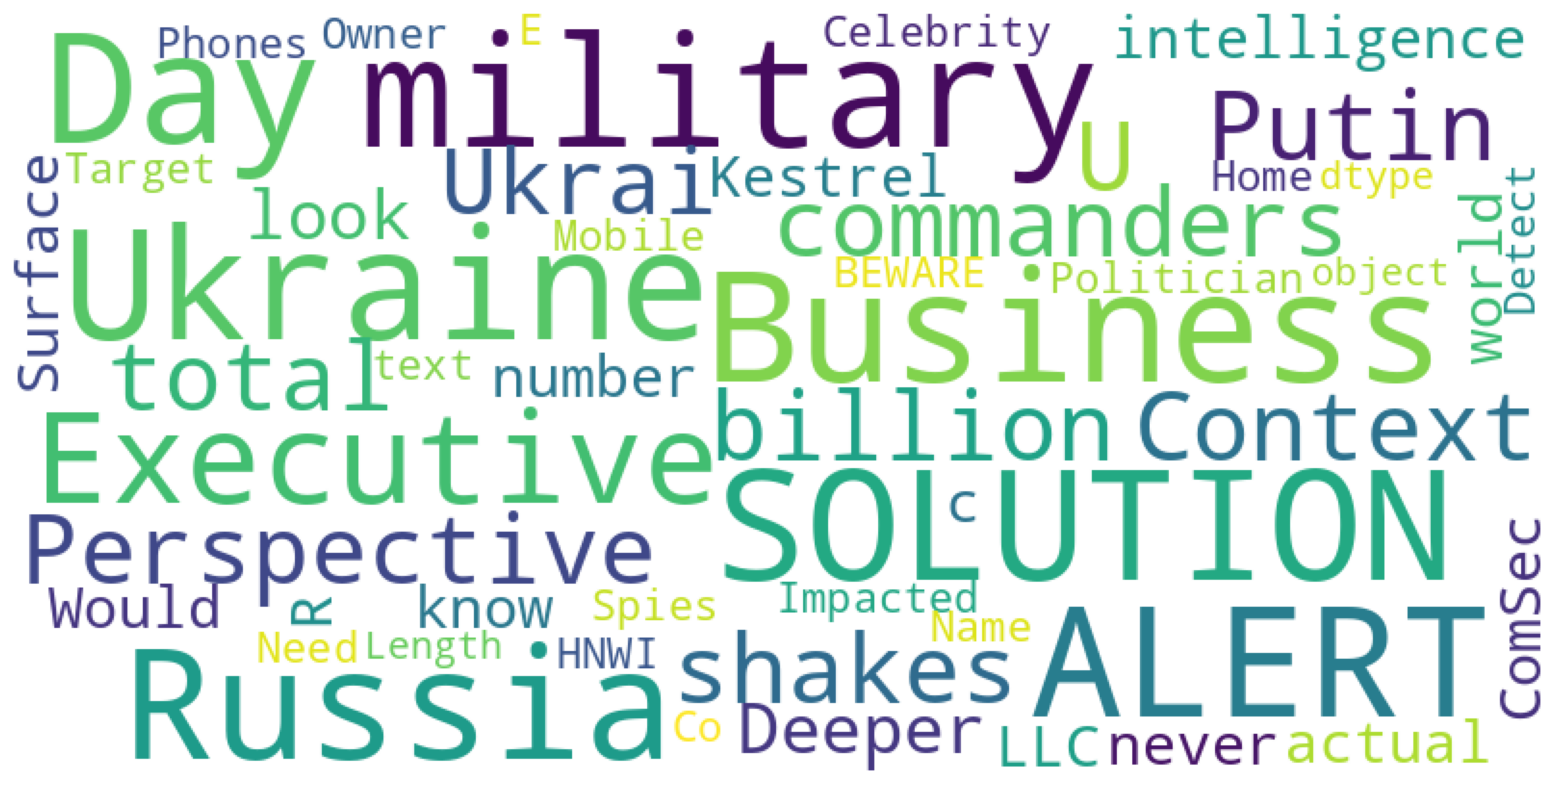

In [35]:
stopwords_set = set(stopwords.words('english'))
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                     max_words = 300,
                     max_font_size = 40,
                      scale = 2,
                     random_state = 42
                     ).generate(str(sort_by_userage.iloc[:1000,columns.index('text')]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

****Bar Plot on User Account Age and classified based on the location of the account****

Top 1000 sorted values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-pa

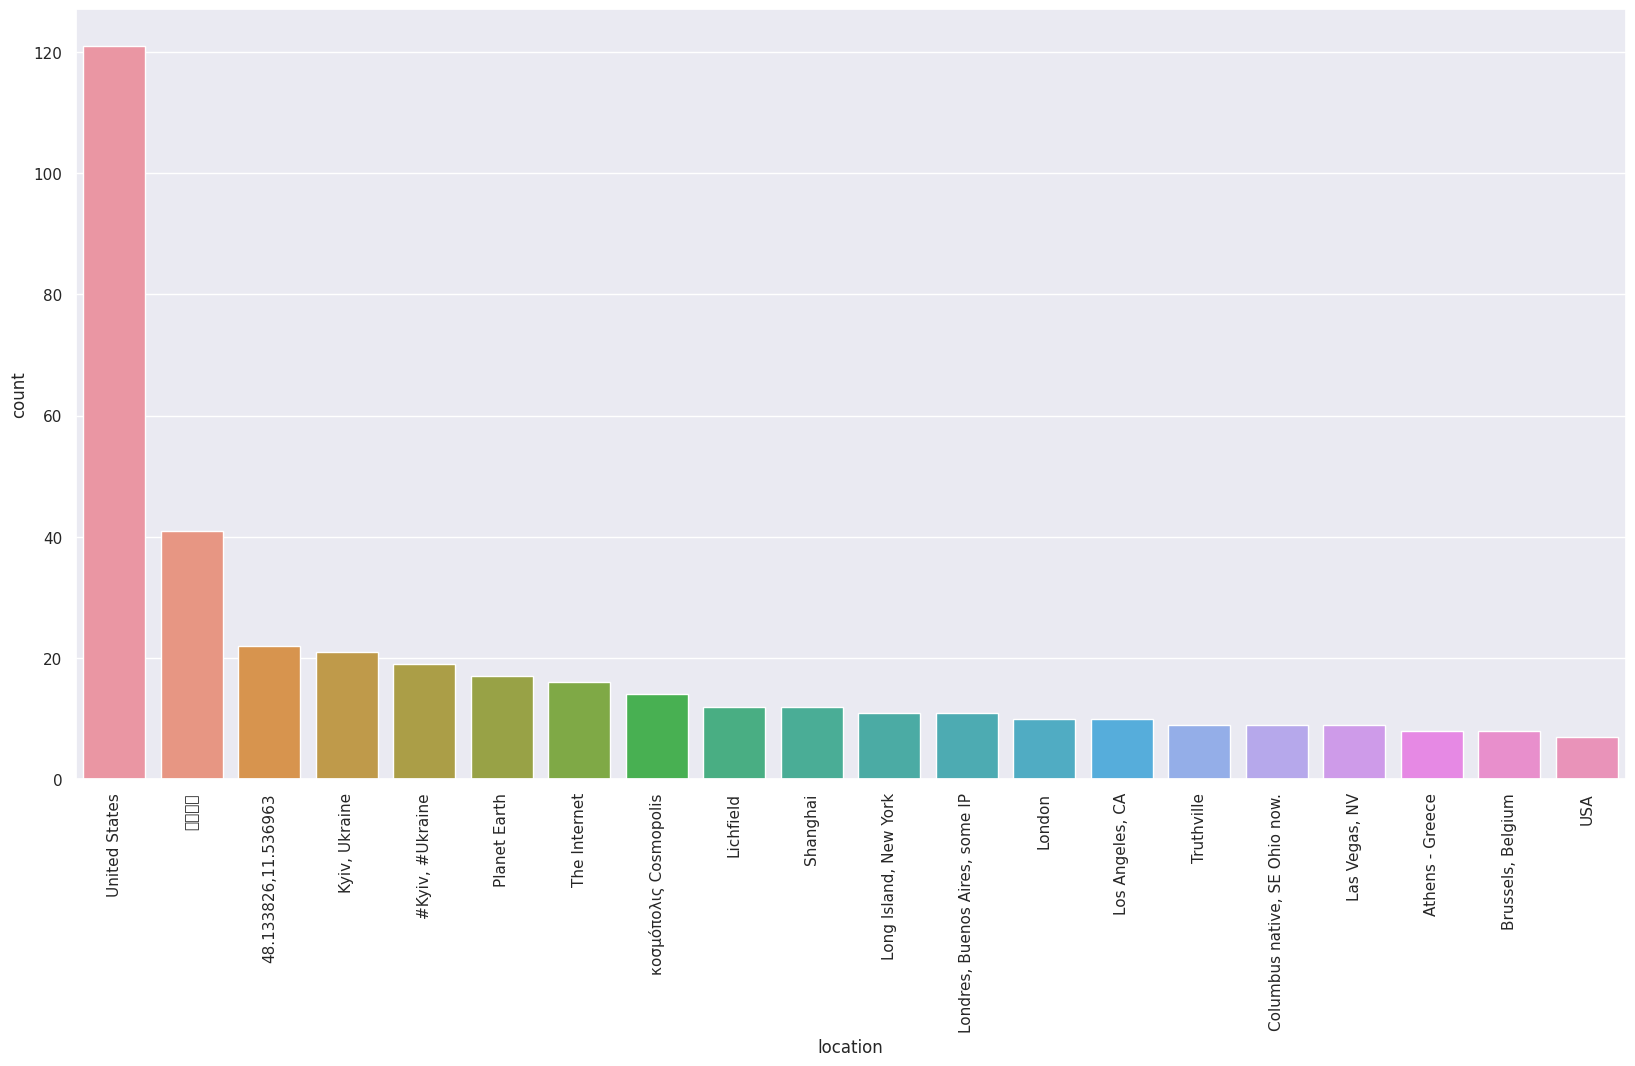

In [36]:
sns.barplot(x = sort_by_userage.iloc[:1000,columns.index('location')].value_counts()[:20].index,
           y = sort_by_userage.iloc[:1000, columns.index('location')].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

Bottom 1000 sorted values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IP

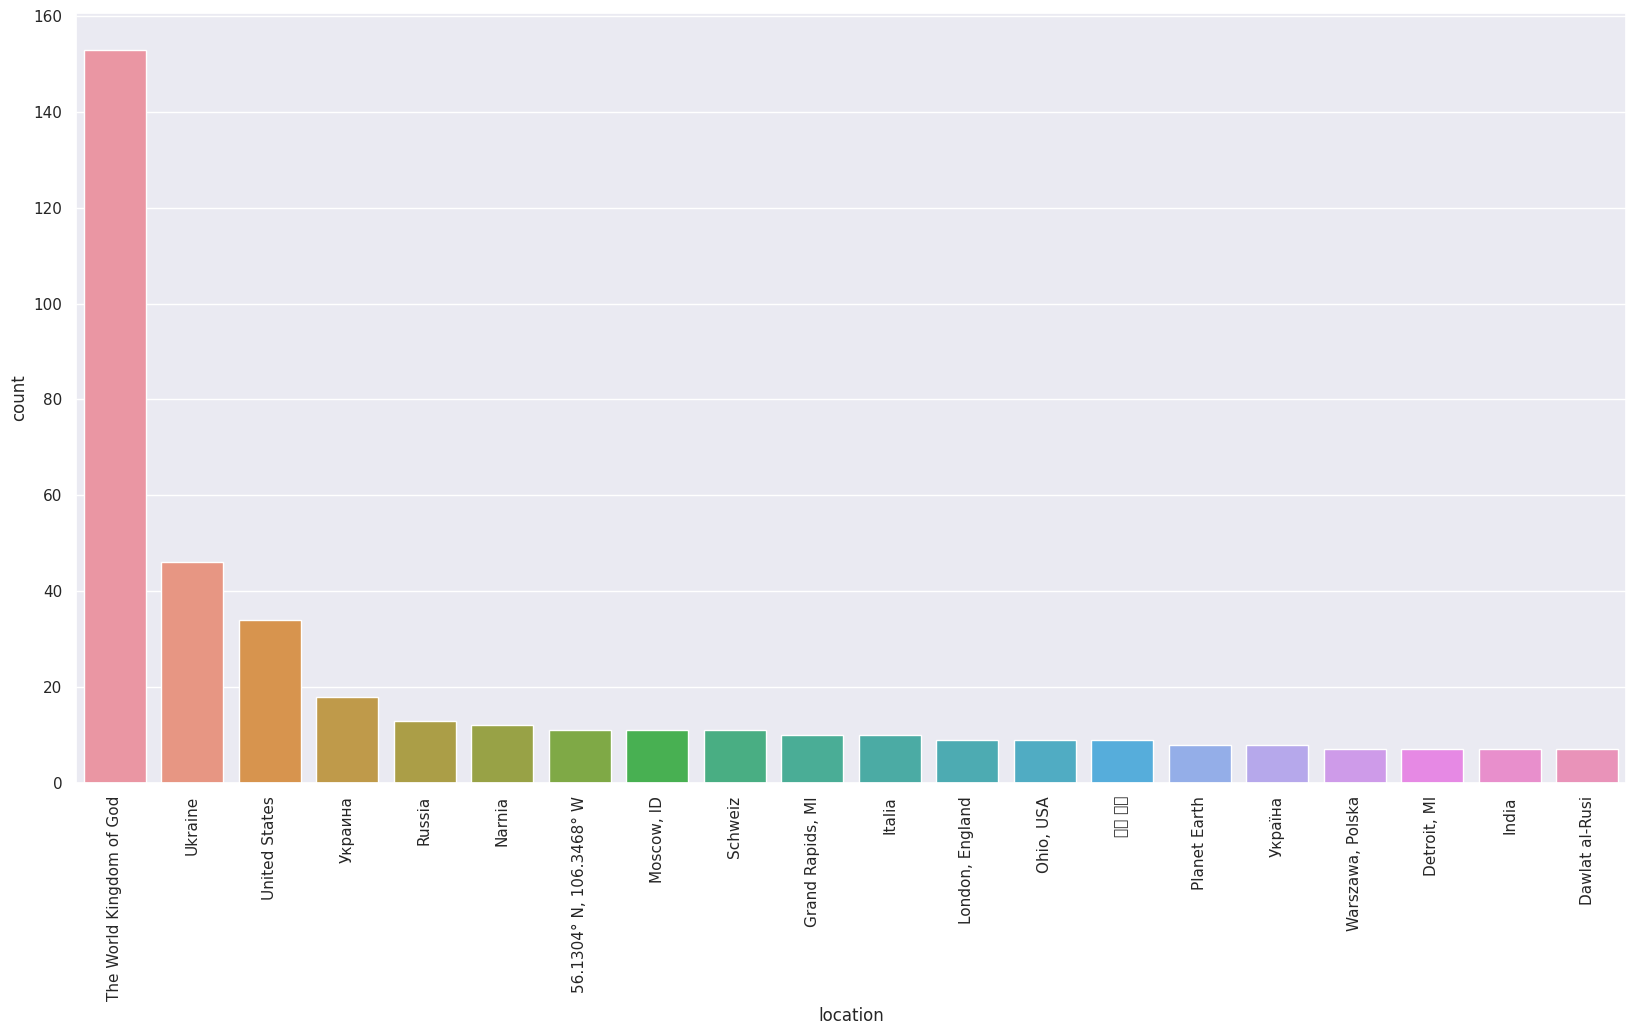

In [37]:
sns.barplot(x = sort_by_userage.iloc[df_en.shape[0]-1000:,
                                    columns.index('location')].value_counts()[:20].index,
           y= sort_by_userage.iloc[df_en.shape[0]-1000:,
                                  columns.index('location')].value_counts()[:20])
plt.xticks(rotation = 90)
plt.show()

**Hastag Analysis**

In [38]:
num_chars = df_en.text.apply(len)
num_words = df_en.text.apply(lambda x: len(x.split()))
df_en['num_chars'] = num_chars
df_en['num_words'] = num_words

In [39]:
print(f"average num characters: {num_chars.mean()}")
print(f"average num words : {num_words.mean()}")
print(f"median num characters: {num_chars.median()}")
print(f"median num words: {num_words.median()}")

average num characters: 214.8208586430557
average num words : 29.32571810974982
median num characters: 229.0
median num words: 30.0


In [40]:
df['tweetcreatedts'] = pd.to_datetime(df['tweetcreatedts'], errors='coerce')
df['extractedts'] = pd.to_datetime(df['extractedts'], errors='coerce') 
gc.collect()

21601

In [41]:
!pip install Unidecode

In [42]:
from unidecode import unidecode
def evaluate_hashtags(x):
    hashtags = []
    
    a = eval(str(x))
    
    for item in a:
        hashtags.append((str(unidecode(item["text"])).lower()))
        hashtags = list(set(hashtags))
        
    return hashtags

In [43]:
masterlist = []
hashtagsListCollection = df["hashtags"].apply(evaluate_hashtags)

for hashtagsList in hashtagsListCollection:
    for hashtag in hashtagsList:
        masterlist.append(hashtag)

In [44]:
topXItem = 25
from collections import Counter

x = Counter(masterlist)

topXItemList = x.most_common(topXItem)

In [45]:
df_hash = pd.DataFrame(topXItemList)
df_hash.columns =['Hashtag','Tweets']
df_hash

Hashtag  Tweets
0              ukraine   35009
1               russia   15268
2                 news   15128
3             business   10383
4                 nato    5587
5             mariupol    5560
6             azovstal    5291
7                  usa    4863
8                putin    4797
9     standwithukraine    4701
10             russian    4663
11               biden    3236
12    ukrainerussiawar    2823
13              crypto    2815
14           marketing    2813
15               bucha    2656
16           ukrainian    2605
17             twitter    2350
18          ukrainewar    2249
19             blogger    2154
20            shopping    2069
21               gifts    2031
22  affiliatemarketing    1991
23        slavaukraini    1990
24                deal    1975

In [46]:
dfpivot = df_hash.T
new_header = dfpivot.iloc[0] #grab the first row for the header
dfpivot = dfpivot[1:] #take the data less the header row
dfpivot.columns = new_header #set the header row as the df header
dfpivot

Hashtag ukraine russia   news business  nato mariupol azovstal   usa putin  \
Tweets    35009  15268  15128    10383  5587     5560     5291  4863  4797   

Hashtag standwithukraine  ... bucha ukrainian twitter ukrainewar blogger  \
Tweets              4701  ...  2656      2605    2350       2249    2154   

Hashtag shopping gifts affiliatemarketing slavaukraini  deal  
Tweets      2069  2031               1991         1990  1975  

[1 rows x 25 columns]

<Axes: xlabel='Hashtag'>

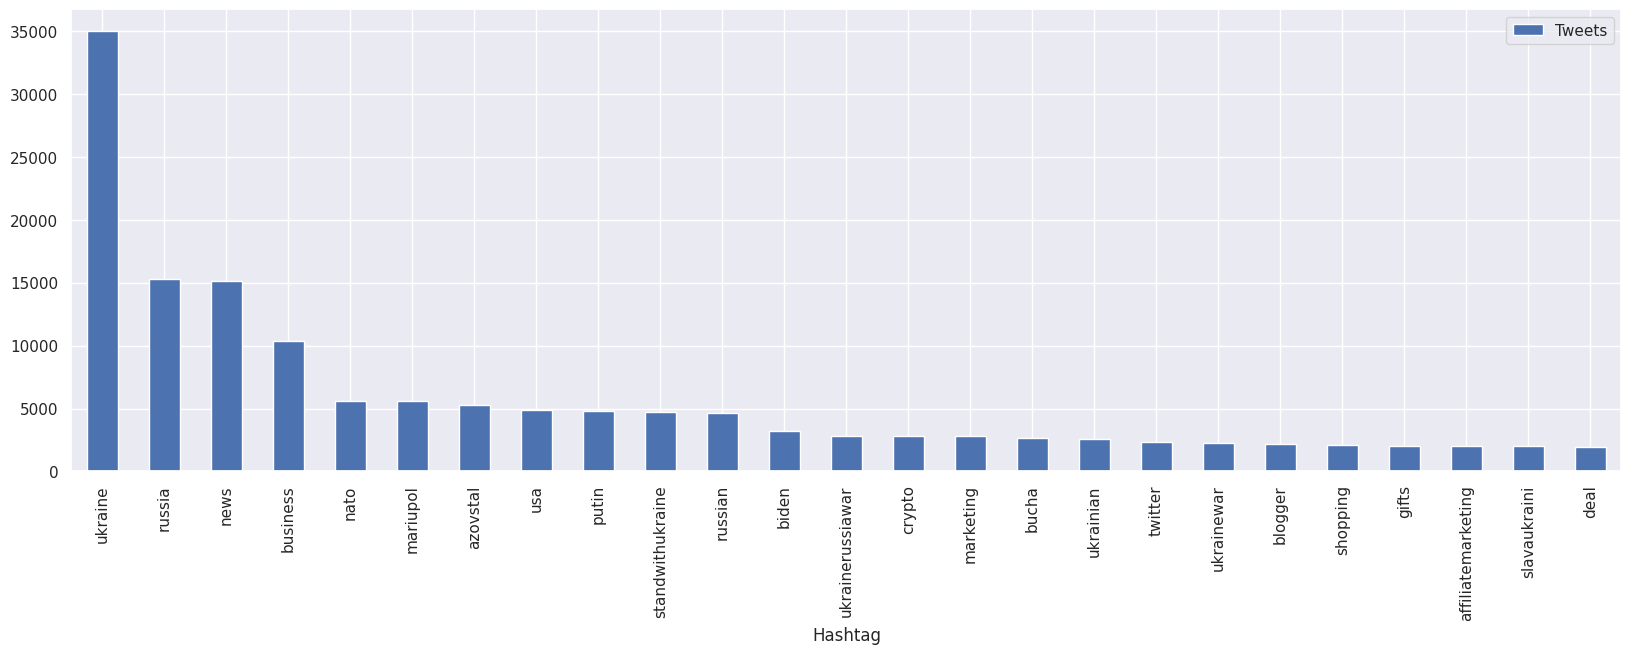

In [47]:
plt.rcParams["figure.figsize"] = [20, 6]
df_hash.plot.bar(x='Hashtag', y='Tweets', rot=90)

**Sentiment Analysis Dataset Builder**

In [48]:
sentiment_df = df[['tweetid', 'text', 'hashtags', 'language']] # Filtering Columns
sentiment_df = sentiment_df.loc[sentiment_df['language'] == 'en'].reset_index(drop=True)  # Filtering language

In [49]:
sentiment_df['hashtags'] = sentiment_df.hashtags.map(lambda x: [i['text'] for i in eval(x)])  # Keeping only hashtags

In [50]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

sentiment_df['text'] = sentiment_df['text'].apply(preprocess)

In [51]:
!pip install transformers

In [52]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# **ROBERTA**

In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [54]:
import urllib
import csv
labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [55]:
from scipy.special import softmax
from tqdm import tqdm
BATCH_SIZE = 10

scores_all = np.empty((0,len(labels)))
text_all = sentiment_df['text'].to_list()
n = len(text_all)
from tqdm import tqdm

# Initialize tqdm with the total number of batches
progress_bar = tqdm(total=n // BATCH_SIZE + 1, desc="Processing")

with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx + BATCH_SIZE, n)
        encoded_input = None

        try:
            # Use 'tokenizer' instead of 'emotion_tokenizer'
            encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)

            output = model(**encoded_input)
            scores = output.logits.detach().cpu().numpy()
            scores = softmax(scores, axis=1)
            scores_all = np.concatenate((scores_all, scores), axis=0)

        except Exception as e:
            print(f"Error at start_idx {start_idx}: {e}")

        finally:
            if encoded_input is not None:
                del encoded_input
            if 'output' in locals():
                del output
            if 'scores' in locals():
                del scores
            torch.cuda.empty_cache()

            # Update the progress bar only if the batch processing is successful
            progress_bar.update(1)

# Close the progress bar
progress_bar.close()

sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)

Processing:  62%|██████▏   | 6006/9714 [03:34<02:49, 21.82it/s]

Error at start_idx 60030: The expanded size of the tensor (665) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [10, 665].  Tensor sizes: [1, 514]


Processing: 100%|█████████▉| 9713/9714 [05:45<00:00, 28.07it/s]


In [56]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", index=False)

# **BOW**

In [57]:
from textblob import TextBlob
def get_sentiment(tweet):
    sentiment = TextBlob(tweet).sentiment
    return sentiment.polarity, sentiment.subjectivity

sentiment_df['sentiment'] = sentiment_df['text'].apply(get_sentiment)

In [58]:
sentiment_df['polarity'] = sentiment_df['sentiment'].apply(lambda x:x[0])
sentiment_df['subjectivity'] = sentiment_df['sentiment'].apply(lambda x:x[0])

In [59]:
sentiment_df.drop('sentiment', axis=1, inplace=True)

In [60]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_BOW_Raw_Values.csv", index=False)

**Emotion Analysis**

In [61]:
emotion_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [62]:
task='emotion'
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [63]:
from scipy.special import softmax
from tqdm import tqdm
BATCH_SIZE = 10

scores_all = np.empty((0,len(labels)))
text_all = sentiment_df['text'].to_list()
n = len(text_all)
from tqdm import tqdm

# Initialize tqdm with the total number of batches
progress_bar = tqdm(total=n // BATCH_SIZE + 1, desc="Processing")

with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx + BATCH_SIZE, n)
        encoded_input = None

        try:
            # Use 'tokenizer' instead of 'emotion_tokenizer'
            encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, truncation=True).to(device)

            output = emotion_model(**encoded_input)
            scores = output.logits.detach().cpu().numpy()
            scores = softmax(scores, axis=1)
            scores_all = np.concatenate((scores_all, scores), axis=0)

        except Exception as e:
            print(f"Error at start_idx {start_idx}: {e}")

        finally:
            if encoded_input is not None:
                del encoded_input
            if 'output' in locals():
                del output
            if 'scores' in locals():
                del scores
            torch.cuda.empty_cache()

            # Update the progress bar only if the batch processing is successful
            progress_bar.update(1)

# Close the progress bar
progress_bar.close()

sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)

Processing:  62%|██████▏   | 6005/9714 [03:37<02:17, 26.91it/s]

Error at start_idx 60030: The expanded size of the tensor (665) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [10, 665].  Tensor sizes: [1, 514]


Processing: 100%|█████████▉| 9713/9714 [05:52<00:00, 27.52it/s]


In [64]:
sentiment_df.to_csv("./Tweets_Emotion_Analysis_RoBERTa_Emotion_Raw_Values.csv", index=False)

# **Sentiment and Emotion Analysis**

**Sentiment Analysis**

Reading the Sentiment CSV data from RoBERTa

In [65]:
tweet_df = pd.read_csv("./Tweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", lineterminator='\n')

Making a new CSV with sentiment rather than score of the sentiments

In [66]:
tweet_df.insert(7, "Sentiment", '')

In [67]:
for i in range(len(tweet_df)):
    if tweet_df['negative'][i] > tweet_df['positive'][i] and tweet_df['negative'][i] > tweet_df['neutral'][i]:
        tweet_df['Sentiment'][i] = 'negative'
    elif tweet_df['positive'][i] > tweet_df['negative'][i] and tweet_df['positive'][i] > tweet_df['neutral'][i]:
        tweet_df['Sentiment'][i] = 'positive'
    else:
        tweet_df['Sentiment'][i] = 'neutral'


In [68]:
tweet_df.drop(['negative','positive','neutral'], axis=1, inplace=True)

In [69]:
tweet_df.drop('language', axis=1, inplace=True)

In [70]:
tweet_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa.csv", index=False)

**Plot for Sentiments**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Sentiment', ylabel='count'>

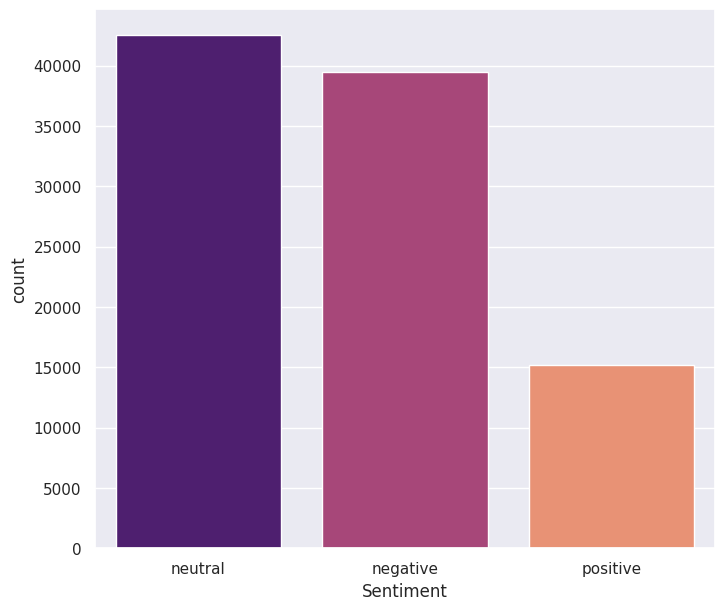

In [71]:
plt.figure(figsize = (8,7))
sns.countplot(x="Sentiment", data=tweet_df, palette='magma')

**WordClouds for Negative, Neutral and Positive Sentiments**

In [72]:
tweet_neg = tweet_df.loc[tweet_df['Sentiment'] == 'negative'].reset_index(drop=True)
tweet_net = tweet_df.loc[tweet_df['Sentiment'] == 'neutral'].reset_index(drop=True)
tweet_pos = tweet_df.loc[tweet_df['Sentiment'] == 'positive'].reset_index(drop=True)

Negative Sentiment

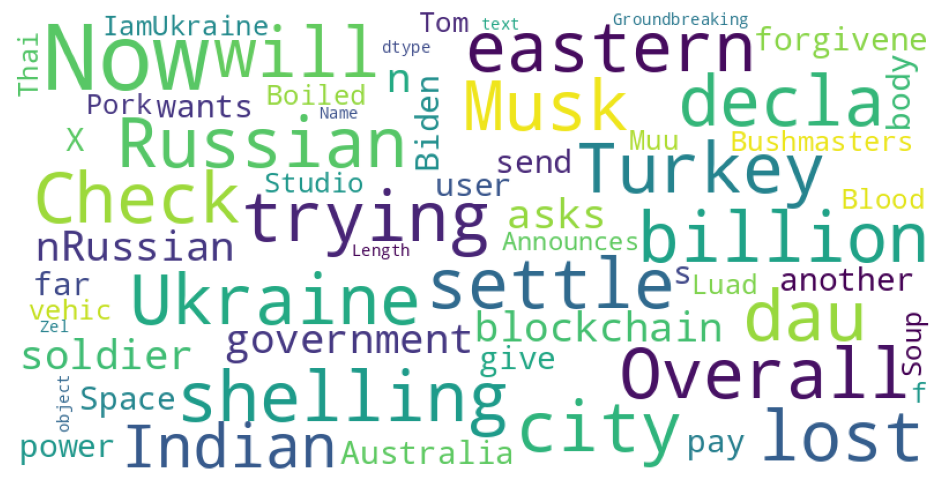

In [73]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_neg['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Neutral Sentiment

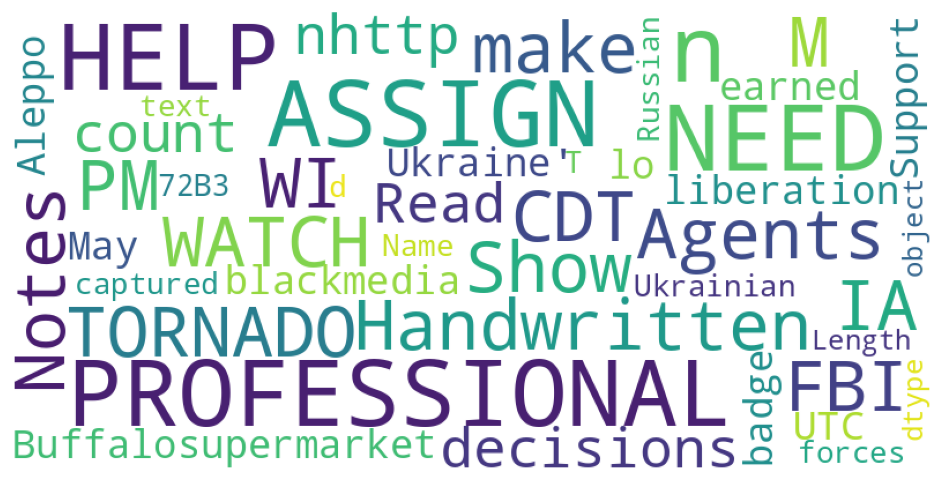

In [74]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_net['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Positive Sentiment

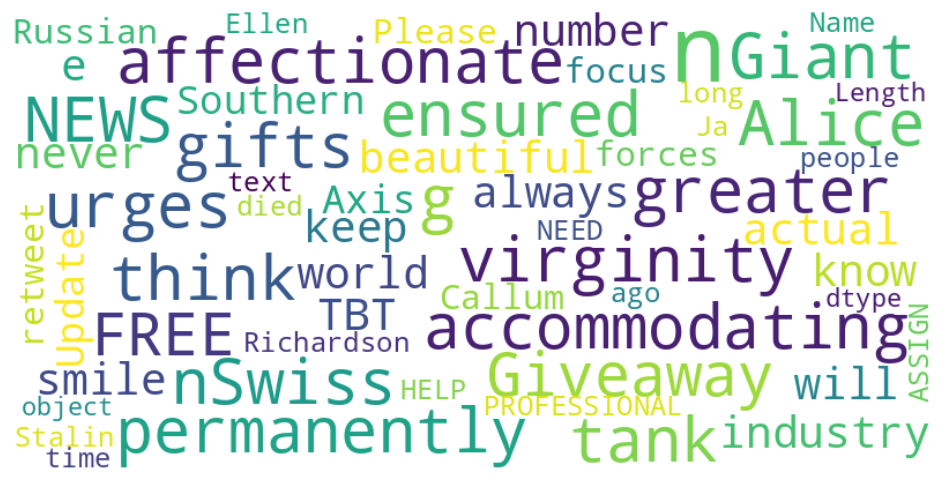

In [75]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(tweet_pos['text']))

print(wordcloud)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

**Pre-Processing the Sentiment Dataframe**

In [76]:
dataset = tweet_df[['Sentiment','text']]
text, sentiment = list(dataset['text']), list(dataset['Sentiment'])

In [77]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [78]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [79]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [80]:
import time
import nltk
from nltk.corpus import wordnet

# Download WordNet dataset
nltk.download('wordnet')
#print(nltk.find('corpora/wordnet.zip'))
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Text Preprocessing complete.
Time Taken: 27 seconds


**Spltting the Dataframe**

In [81]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature_words:  495701


In [83]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Evaluation

**Bernoulli**

In [84]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
ys_predict = BNBmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.73      0.66      0.70      1941
     neutral       0.62      0.83      0.71      2190
    positive       0.84      0.22      0.35       726

    accuracy                           0.67      4857
   macro avg       0.73      0.57      0.59      4857
weighted avg       0.70      0.67      0.65      4857

Accuracy Score:  0.6720197652872143


**K Nearest Neighbors**

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Apply StandardScaler to standardize features
scaler = StandardScaler(with_mean=False)  # Specify with_mean=False for sparse matrix
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply TruncatedSVD to reduce dimensionality (similar to PCA for sparse data)
svd = TruncatedSVD(n_components=500)  # Adjust the number of components based on your needs
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

# Train KNN model on the reduced-dimensional data
KNNModel = KNeighborsClassifier(n_neighbors=5)
KNNModel.fit(X_train_svd, y_train)
ys_predict = KNNModel.predict(X_test_svd)

# Display the outcome of classification
print('Classification Report: \n', metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ', metrics.accuracy_score(y_test, ys_predict))


**Decision Tree Classifier**

In [ ]:
DTCModel = DecisionTreeClassifier(random_state=0)
DTCModel.fit(X_train, y_train)
ys_predict = DTCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

**Random Forest Classifier**

In [ ]:
RFCModel = RandomForestClassifier(n_estimators=100)
RFCModel.fit(X_train, y_train)
ys_predict = RFCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

**Logistic Regression**

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
ys_predict = LRmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

**Support Vector Classification**

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
ys_predict = SVCmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

# Emotion Analysis

**Reading the Emotion CSV data from RoBERTa**

In [91]:
emotion_df = pd.read_csv("./Tweets_Emotion_Analysis_RoBERTa_Emotion_Raw_Values.csv", lineterminator='\n')

**Making a new CSV with emotion rather than score of the sentiments**

In [92]:
emotion_df.drop(['negative','positive','neutral','polarity','subjectivity','language'], axis=1, inplace=True)

In [93]:
emotion_df.insert(7, "Emotion", '')

In [94]:
for i in range(len(emotion_df)):
    if emotion_df['anger'][i] > emotion_df['joy'][i] and emotion_df['anger'][i] > emotion_df['optimism'][i] and emotion_df['anger'][i] > emotion_df['sadness'][i]:
        emotion_df['Emotion'][i] = 'anger'
    elif emotion_df['joy'][i] > emotion_df['anger'][i] and emotion_df['joy'][i] > emotion_df['optimism'][i] and emotion_df['joy'][i] > emotion_df['sadness'][i]:
        emotion_df['Emotion'][i] = 'joy'
    elif emotion_df['optimism'][i] > emotion_df['anger'][i] and emotion_df['optimism'][i] > emotion_df['joy'][i] and emotion_df['optimism'][i] > emotion_df['sadness'][i]:
        emotion_df['Emotion'][i] = 'optimism'
    else:
        emotion_df['Emotion'][i] = 'sadness'


In [95]:
emotion_df.drop(['anger','joy','optimism','sadness'], axis=1, inplace=True)

In [96]:
emotion_df.to_csv("./Tweets_Emotion_Analysis_RoBERTa.csv", index=False)

**Plot for Emotions**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Emotion', ylabel='count'>

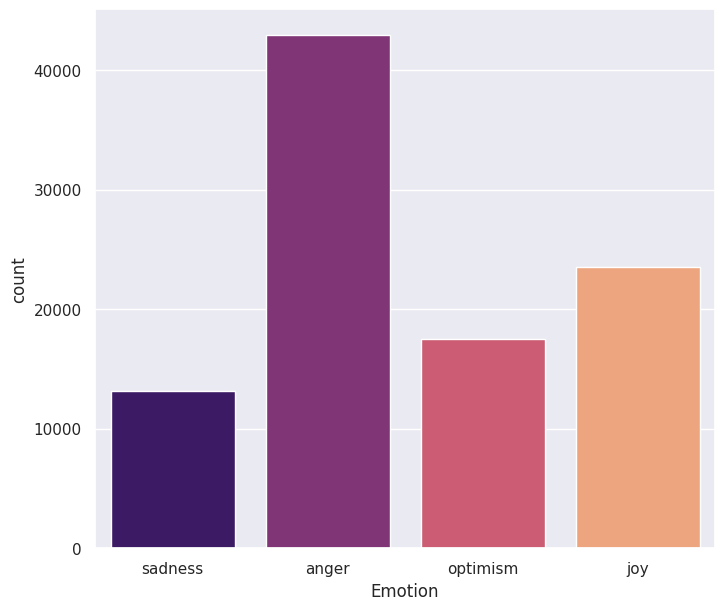

In [97]:
plt.figure(figsize = (8,7))
sns.countplot(x="Emotion", data=emotion_df, palette='magma')

**WordClouds for Anger, Joy, Optimism and Sadness Emotions**

In [98]:
emotion_anger = emotion_df.loc[emotion_df['Emotion'] == 'anger'].reset_index(drop=True)
emotion_joy = emotion_df.loc[emotion_df['Emotion'] == 'joy'].reset_index(drop=True)
emotion_opt = emotion_df.loc[emotion_df['Emotion'] == 'optimism'].reset_index(drop=True)
emotion_sad = emotion_df.loc[emotion_df['Emotion'] == 'sadness'].reset_index(drop=True)

**Emotion - Anger**

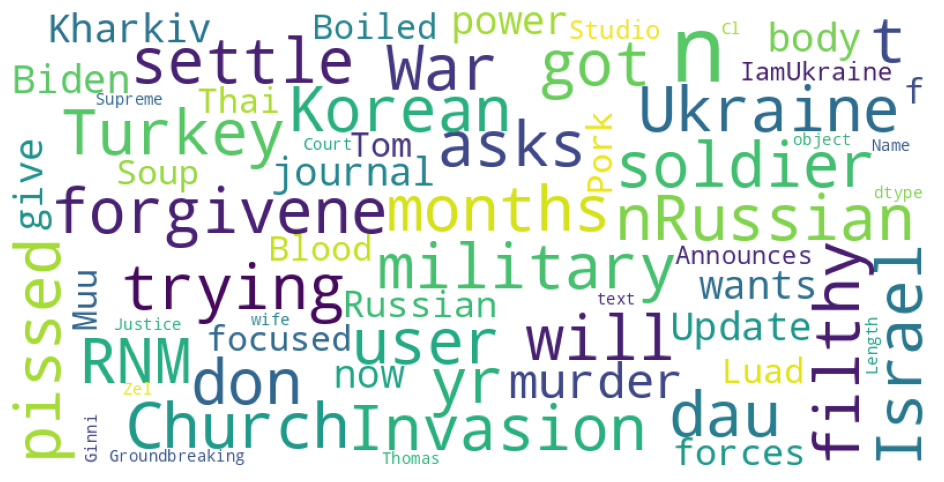

In [99]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_anger['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Emotion - Joy**

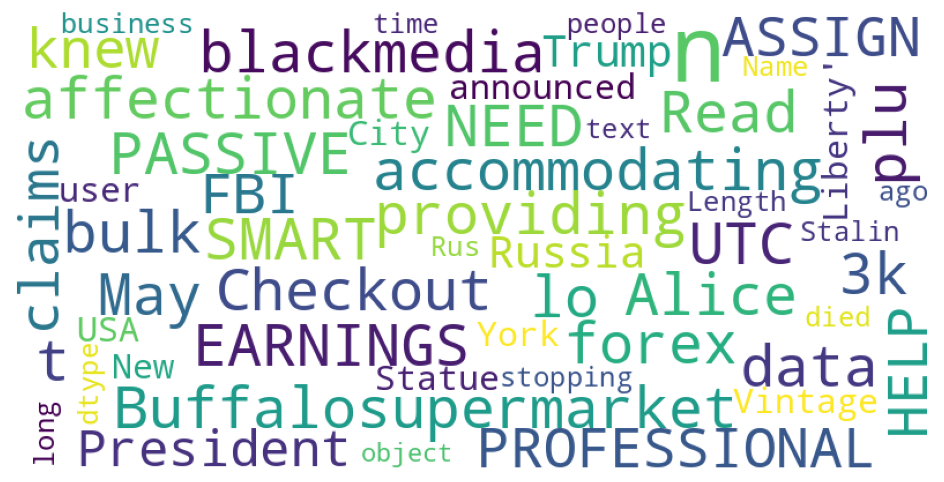

In [100]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_joy['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Emotion - Optimism**

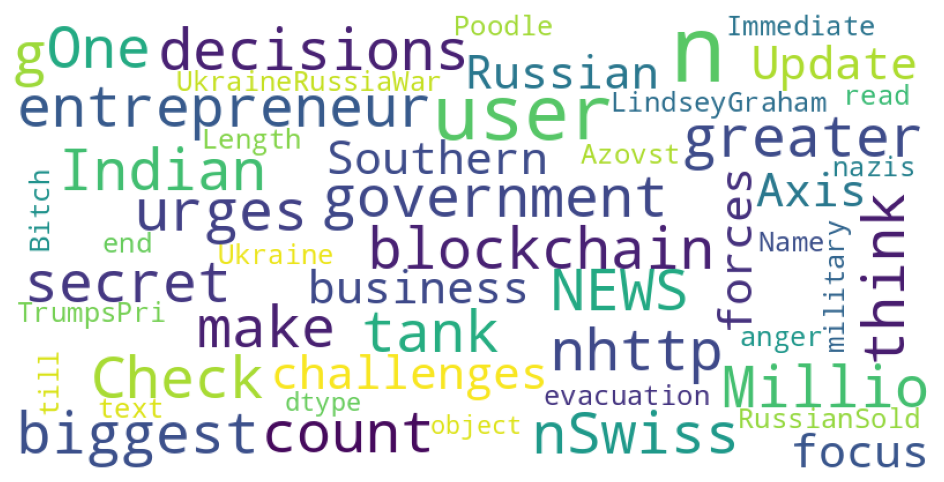

In [101]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_opt['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Emotion - Sadness**

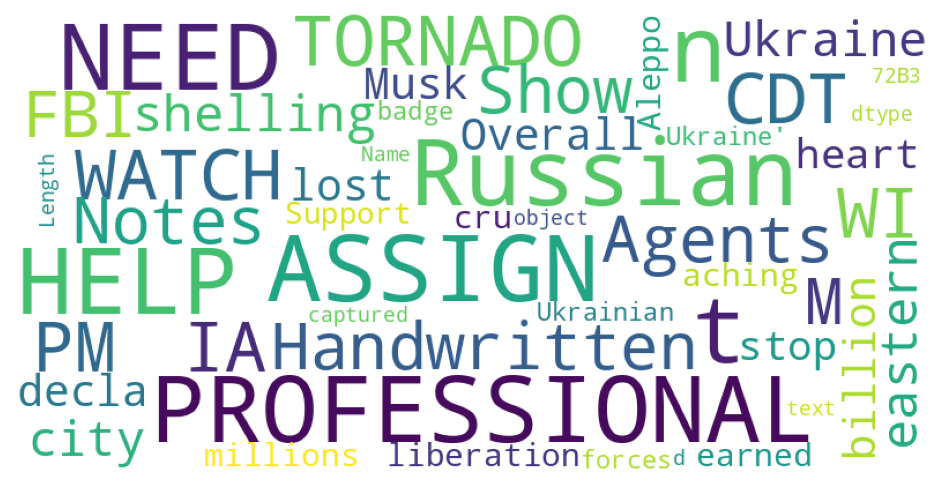

In [102]:
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(emotion_sad['text']))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Pre-Processing the Emotion Dataframe**

In [104]:
dataset = emotion_df[['Emotion','text']]
text, emotion = list(dataset['text']), list(dataset['Emotion'])

**Splitting the Dataframe**

In [105]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, emotion,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)

print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature_words:  495701


In [108]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')


Data Transformed.


# Evaluation

**Bernoulli**

In [109]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
ys_predict = BNBmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

       anger       0.56      0.92      0.70      2099
         joy       0.68      0.48      0.56      1154
    optimism       0.80      0.26      0.40       908
     sadness       0.81      0.35      0.49       696

    accuracy                           0.61      4857
   macro avg       0.71      0.50      0.54      4857
weighted avg       0.67      0.61      0.58      4857

Accuracy Score:  0.6116944616018118


**K Nearest Neighbor**

In [ ]:
KNNModel = KNeighborsClassifier(n_neighbors=5)
KNNModel.fit(X_train, y_train)
ys_predict = KNNModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))


**Decision Tree Classifier**

In [ ]:
DTCModel = DecisionTreeClassifier(random_state=0)
DTCModel.fit(X_train, y_train)
ys_predict = DTCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

**Random Forest Classifier**

In [ ]:
RFCModel = RandomForestClassifier(n_estimators=100)
RFCModel.fit(X_train, y_train)
ys_predict = RFCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

**Logistic Regression**

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
ys_predict = LRmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))

**Support Vector Machine**

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
ys_predict = SVCmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Accuracy Score: ',metrics.accuracy_score(y_test, ys_predict))
